## Assignment 4

This assignment is based on content discussed in module 8 and using Decision Trees and Ensemble Models in classification and regression problems.

## Learning outcomes 

- Understand how to use decision trees on a Dataset to make a prediction
- Learning hyper-parameters tuning for decision trees by using RandomGrid 
- Learning the effectiveness of ensemble algorithms (Random Forest, Adaboost, Extra trees classifier, Gradient Boosted Tree)

In the first part of this assignment, you will use Classification Trees for predicting if a user has a default payment option active or not. You can find the necessary data for performing this assignment [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) 

This dataset is aimed at the case of customer default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default.

Required imports for this project are given below. Make sure you have all libraries required for this project installed. You may use conda or pip based on your set up.

__NOTE:__ Since data is in Excel format you need to install `xlrd` in order to read the excel file inside your pandas dataframe. You can run `pip install xlrd` to install 

In [1]:
#required imports
import numpy as np
import pandas as pd
random_state = 42

# %pip install xlrd

In [2]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.compose import ColumnTransformer #for selecting specific columns and transforming them with individual pipelines
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler #specific transformations we want to use in our pipelines
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

##plot a pie chart for the target to see if data are balanced
def check_data_balance(series, style="ggplot"):
    with plt.style.context(style):
        unique = series.value_counts()
        display(unique)  # shows unique value counts of the target
        plt.pie(unique, 
                explode=[0.05]*len(unique), 
                labels=unique.index, 
                autopct='%1.1f%%')
        plt.show() 

In [5]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Score")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation Score")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve - {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
model_results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "ROC AUC": []
}

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(name, y_true, y_pred, y_proba):
    model_results["Model"].append(name)
    model_results["Accuracy"].append(accuracy_score(y_true, y_pred))
    model_results["Precision"].append(precision_score(y_true, y_pred, pos_label=1))
    model_results["Recall"].append(recall_score(y_true, y_pred, pos_label=1))
    model_results["F1 Score"].append(f1_score(y_true, y_pred, pos_label=1))
    model_results["ROC AUC"].append(roc_auc_score(y_true, y_proba[:, 1]))

In [8]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

def plot_roc(model_name, y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

After installing the necessary libraries, proceed to download the data. Since reading the excel file won't create headers by default, we added two more operations to substitute the columns.

In [9]:
#loading the data
df= pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",header=1)
# dataset.columns = dataset.iloc[0]
df.drop(columns=['ID'], inplace=True)

In the following, you can take a look into the dataset.

In [10]:
df.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0


In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [12]:
df_discovery = df.copy()

In [13]:
print(df_discovery.isnull().sum().sum(), " missing values in the dataset.")

0  missing values in the dataset.


In [14]:
df_discovery.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


default payment next month
0    23364
1     6636
Name: count, dtype: int64

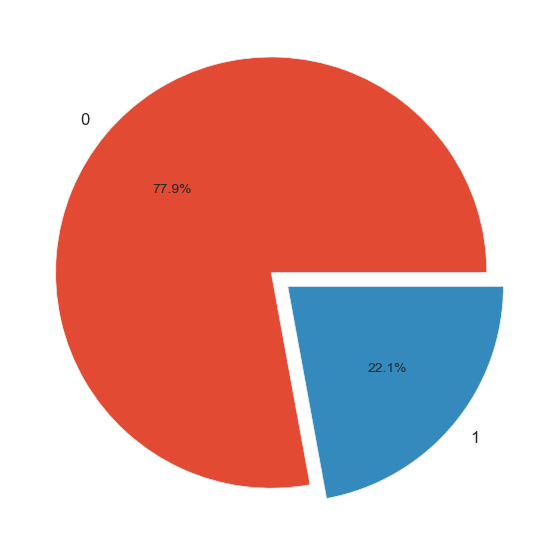

In [15]:
check_data_balance(df_discovery["default payment next month"])

# Light Data Transformation

In [16]:
# Update EDUCATION: 0 -> 4 (Other)
df['EDUCATION'] = df['EDUCATION'].replace(0, 4)
df['EDUCATION'] = df['EDUCATION'].replace(5, 4)
df['EDUCATION'] = df['EDUCATION'].replace(6, 4)

# Update MARRIAGE: 0 -> 3 (Other)
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

print("Updated EDUCATION value counts:")
display(df['EDUCATION'].value_counts(normalize=True))

print("\nUpdated MARRIAGE value counts:")
display(df['MARRIAGE'].value_counts(normalize=True))

Updated EDUCATION value counts:


EDUCATION
2    0.467667
1    0.352833
3    0.163900
4    0.015600
Name: proportion, dtype: float64


Updated MARRIAGE value counts:


MARRIAGE
2    0.532133
1    0.455300
3    0.012567
Name: proportion, dtype: float64

In [17]:
TARGET = "default payment next month"
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_categorical = ["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: default payment next month
columns_predictors: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
columns_categorical: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [18]:
X = df[columns_predictors]
y = df[TARGET]
display(X)
display(y)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,80000,1,3,1,41,1,-1,0,0,0,...,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment next month, Length: 30000, dtype: int64

In [19]:
pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder(handle_unknown="ignore")),
])

pipeline_numerical = Pipeline([
  ('scaler', RobustScaler()),
])

pipeline_full = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_categorical),
  ("numerical", pipeline_numerical, columns_numerical),
])

In [20]:
pipeline_full

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                  'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6']),
                                ('numerical',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6'])])

## Questions (15 points total)

#### Question 1 (2 pts)
Build a classifier by using decision tree and calculate the confusion matrix. Try different hyper-parameters (at least two) and discuss the result.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
X_train = pipeline_full.fit_transform(X_train)
X_test = pipeline_full.transform(X_test)

In [22]:
feature_names = pipeline_full.get_feature_names_out(input_features=X.columns)
class_names=["No Default", "Default"]

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [24]:
# First tree
tree_1 = DecisionTreeClassifier(max_depth=3, criterion='gini', random_state=random_state)
tree_1.fit(X_train, y_train)
y_pred_1 = tree_1.predict(X_test)
y_proba_1 = tree_1.predict_proba(X_test)

# Second tree
tree_2 = DecisionTreeClassifier(max_depth=5, min_samples_split=1000, criterion='entropy', random_state=random_state)
tree_2.fit(X_train, y_train)
y_pred_2 = tree_2.predict(X_test)
y_proba_2 = tree_2.predict_proba(X_test)

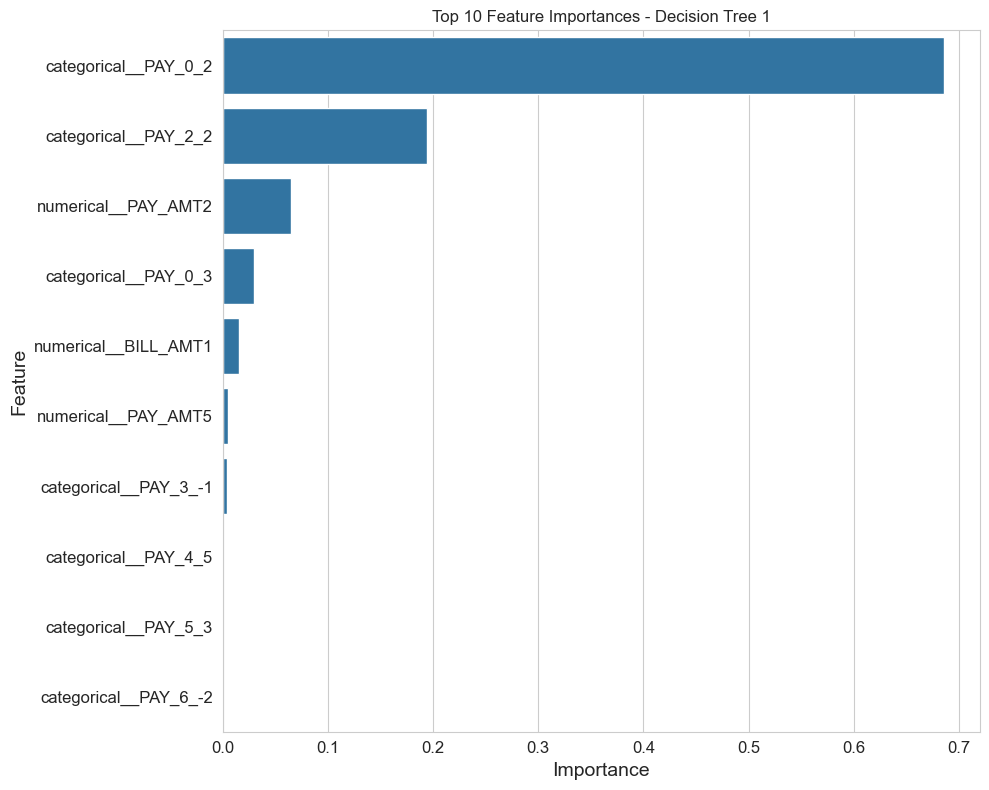

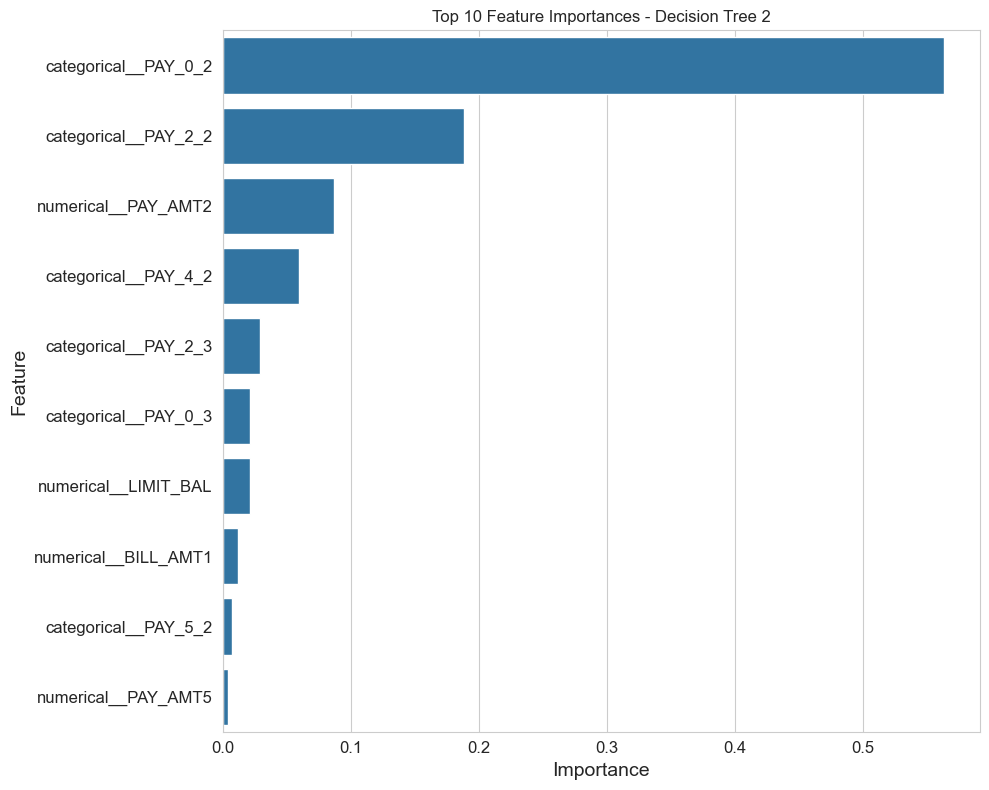

In [25]:
importances = tree_1.feature_importances_
feature_importance_tree_1 = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

importances = tree_2.feature_importances_
feature_importance_tree_2 = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_tree_1.head(10))
plt.title("Top 10 Feature Importances - Decision Tree 1")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_tree_2.head(10))
plt.title("Top 10 Feature Importances - Decision Tree 2")
plt.tight_layout()
plt.show()

Decision Tree 1 (max_depth=3, gini)


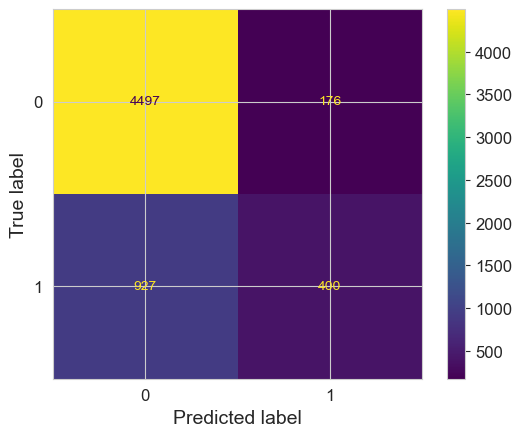

              precision    recall  f1-score   support

           0      0.829     0.962     0.891      4673
           1      0.694     0.301     0.420      1327

    accuracy                          0.816      6000
   macro avg      0.762     0.632     0.656      6000
weighted avg      0.799     0.816     0.787      6000



Decision Tree 2 (max_depth=5, min_samples_split=1000, entropy


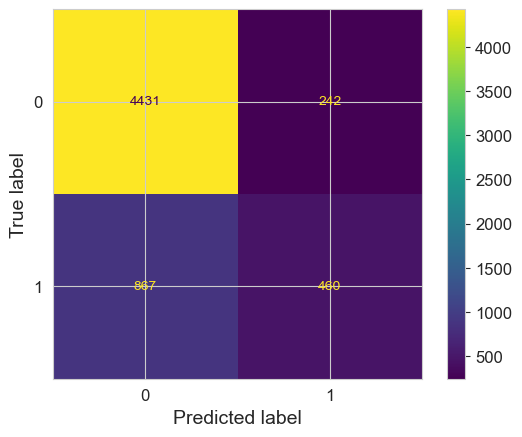

              precision    recall  f1-score   support

           0      0.836     0.948     0.889      4673
           1      0.655     0.347     0.453      1327

    accuracy                          0.815      6000
   macro avg      0.746     0.647     0.671      6000
weighted avg      0.796     0.815     0.792      6000



In [26]:
print("Decision Tree 1 (max_depth=3, gini)")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1)
plt.show()
print(classification_report(y_test, y_pred_1, digits=3))

print("\n\nDecision Tree 2 (max_depth=5, min_samples_split=1000, entropy")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2)
plt.show()
print(classification_report(y_test, y_pred_2, digits=3))

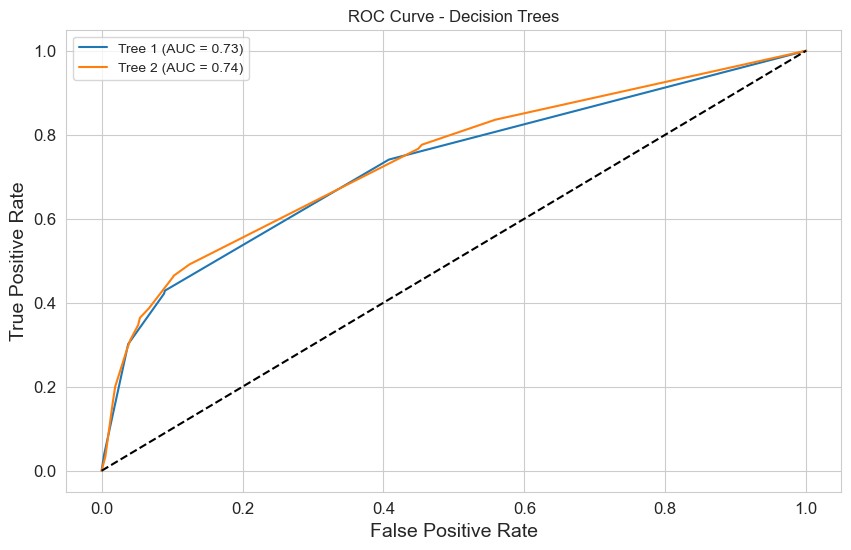

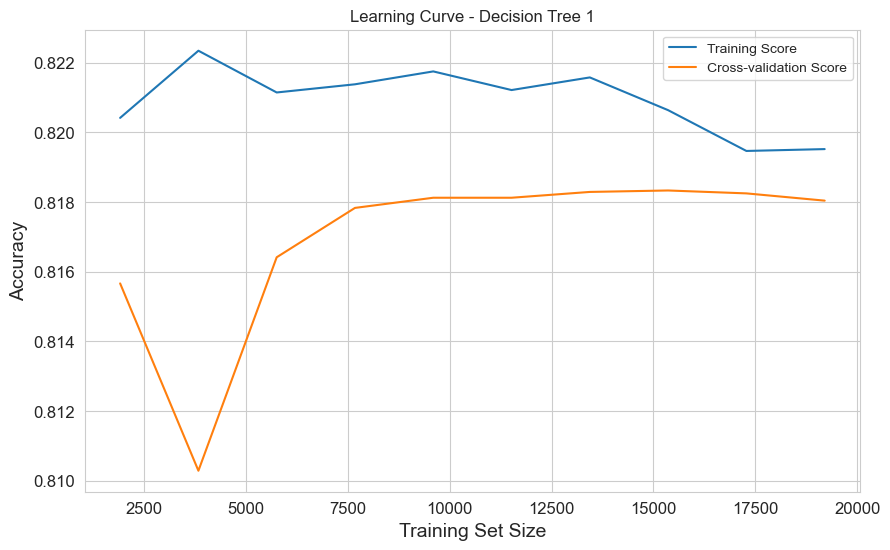

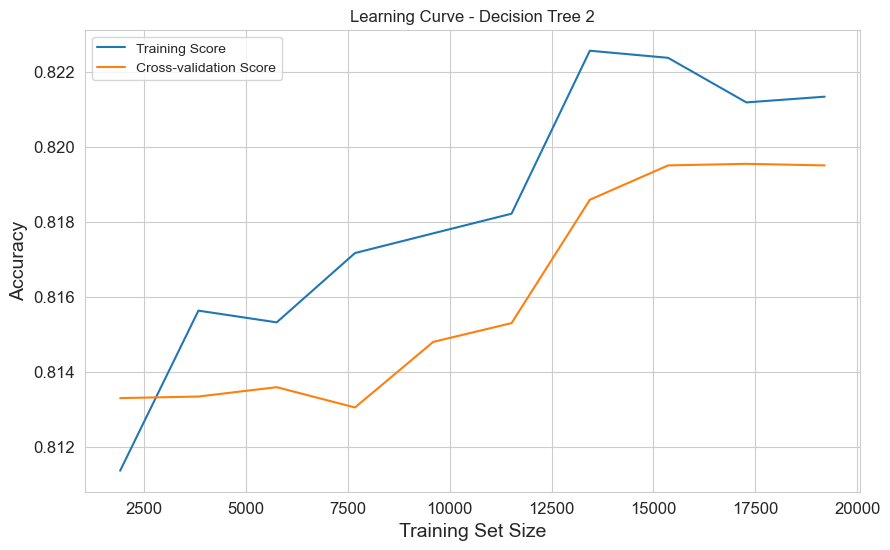

In [27]:
# ROC curve for Decision Trees
plt.figure(figsize=(10, 6))
plot_roc("Tree 1", y_test, y_proba_1)
plot_roc("Tree 2", y_test, y_proba_2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Trees")
plt.legend()
plt.grid(True)
plt.show()

# Learning curves
plot_learning_curve(tree_1, "Decision Tree 1")
plot_learning_curve(tree_2, "Decision Tree 2")


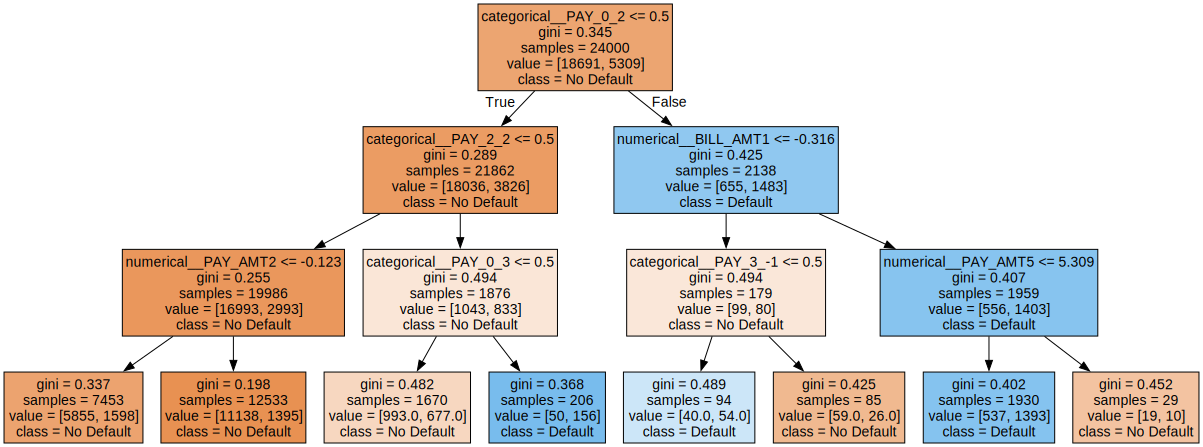

In [28]:
# Tree 1
graph_1 = Source(export_graphviz(tree_1, out_file=None, feature_names=feature_names, class_names=class_names, filled=True))
display(SVG(graph_1.pipe(format='svg')))

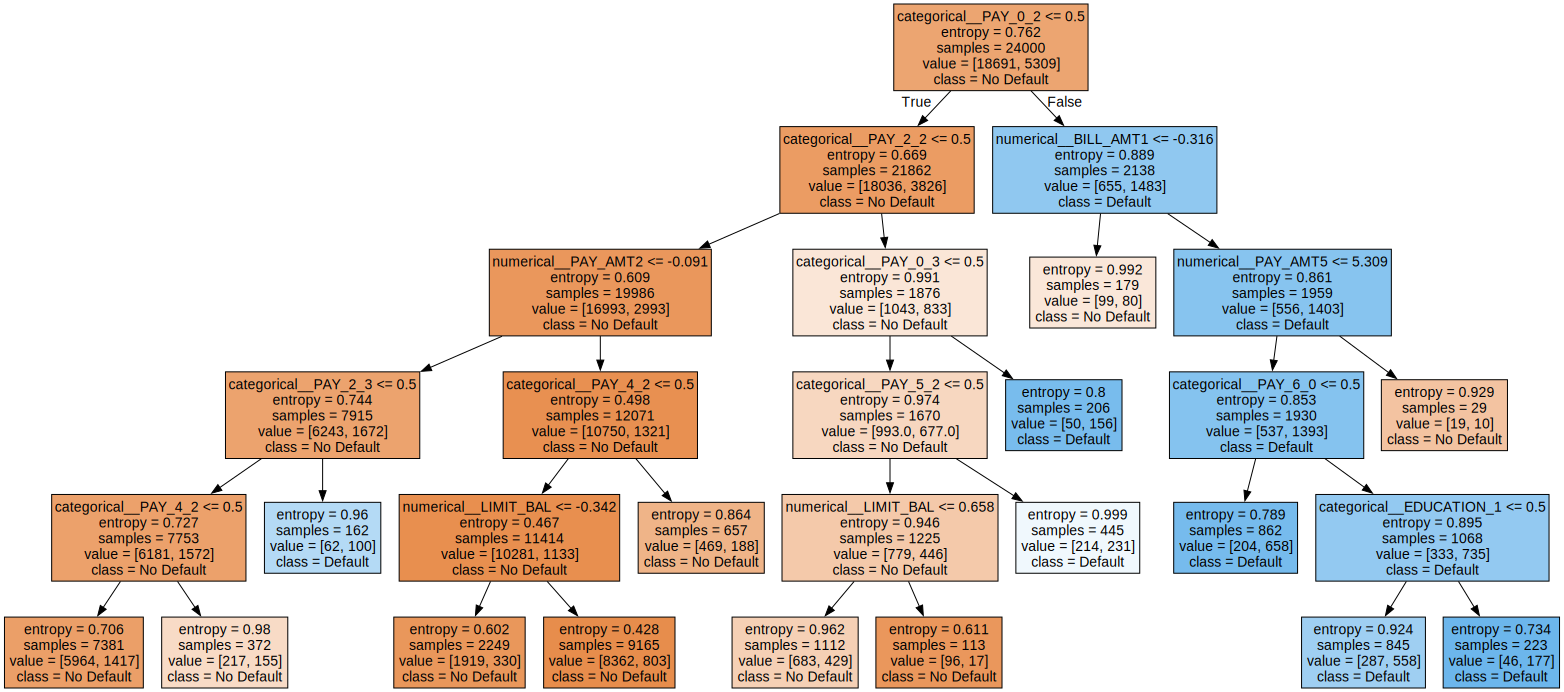

In [29]:
# Tree 2
graph_2 = Source(export_graphviz(tree_2, out_file=None, feature_names=feature_names, class_names=class_names, filled=True))
display(SVG(graph_2.pipe(format='svg')))


#### Question 2 (4 pts)

Try to build the decision tree which you built for the previous question, but this time by RandomizedSearchCV over hyper-parameters. Compare the results.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'max_depth': randint(3, 15),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 20)
}

random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=random_state),
    param_distributions=param_dist,
    n_iter=25,
    scoring='accuracy',
    cv=5,
    random_state=random_state,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
tree_3 = random_search.best_estimator_

print("Best parameters from RandomizedSearchCV:", random_search.best_params_)

Best parameters from RandomizedSearchCV: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 12, 'min_samples_split': 4}


In [31]:
y_pred_gs = tree_3.predict(X_test)
y_proba_gs = tree_3.predict_proba(X_test)

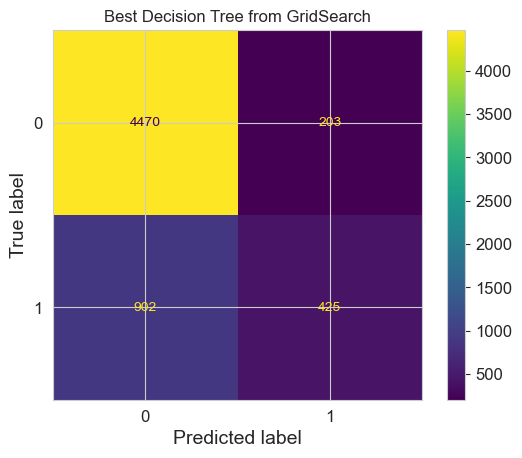

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.68      0.32      0.43      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000



In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gs)
plt.title("Best Decision Tree from GridSearch")
plt.show()
print(classification_report(y_test, y_pred_gs))

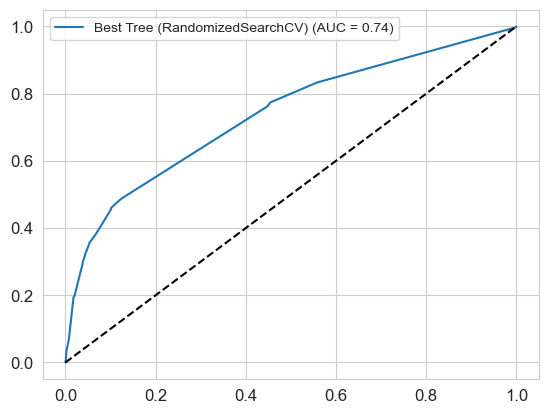

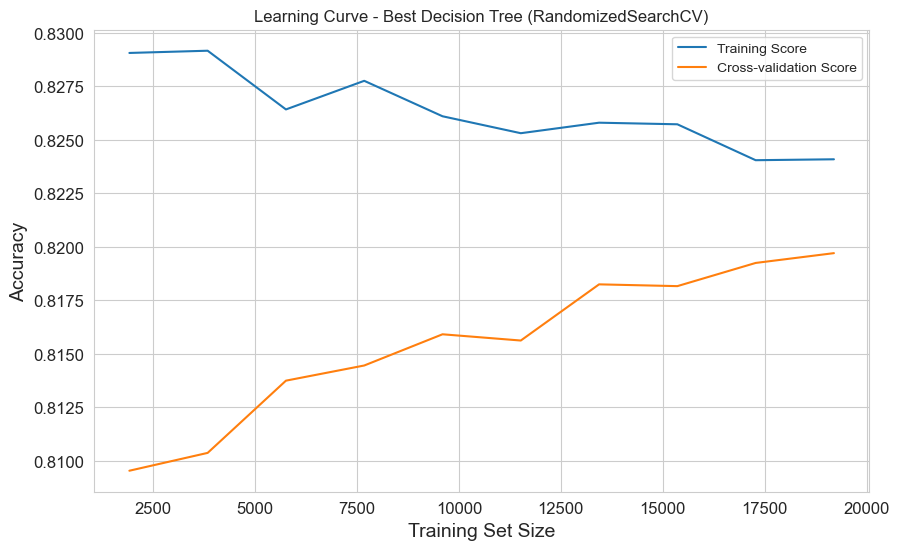

In [33]:
# ROC and learning curve
plot_roc("Best Tree (RandomizedSearchCV)", y_test, y_proba_gs)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.grid(True)
plt.show()
plot_learning_curve(tree_3, "Best Decision Tree (RandomizedSearchCV)")

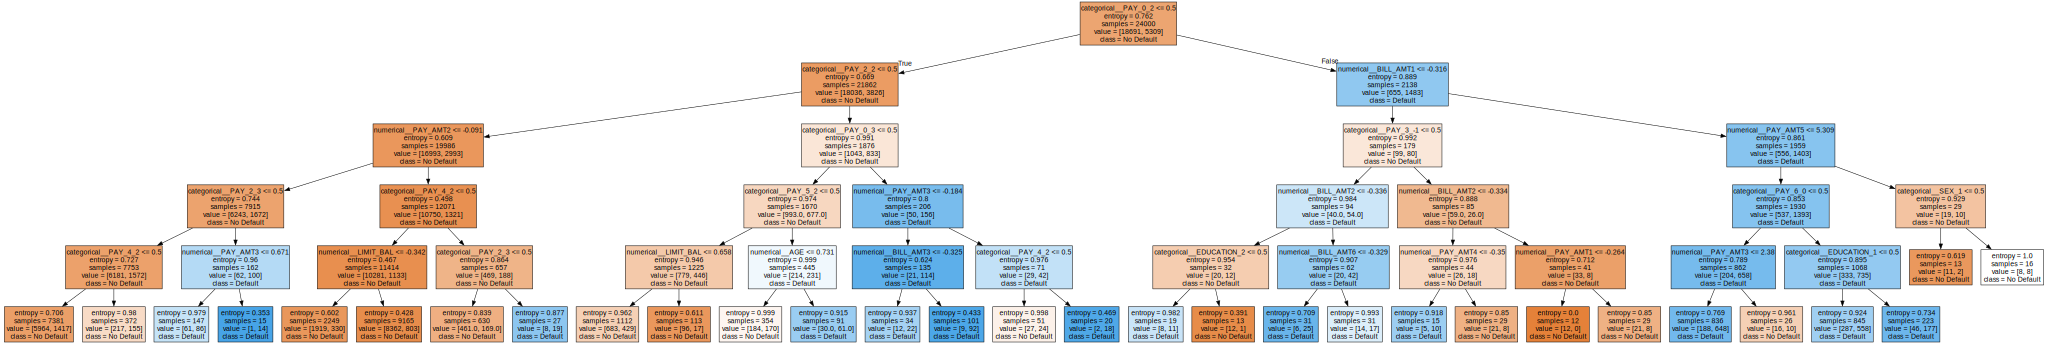

In [34]:
# Tree 2
graph_3 = Source(export_graphviz(tree_3, out_file=None, feature_names=feature_names, class_names=class_names, filled=True))
display(SVG(graph_3.pipe(format='svg')))

#### Question 3 (6 pts)

Try to build the same classifier by using following ensemble models. For each of these models calculate accuracy and at least for two in the list below, plot the learning curves.

* Random Forest 
* AdaBoost
* Extra Trees Classifier 
* Gradient Boosted Trees 


In [35]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)

## Random Forest

Random Forest


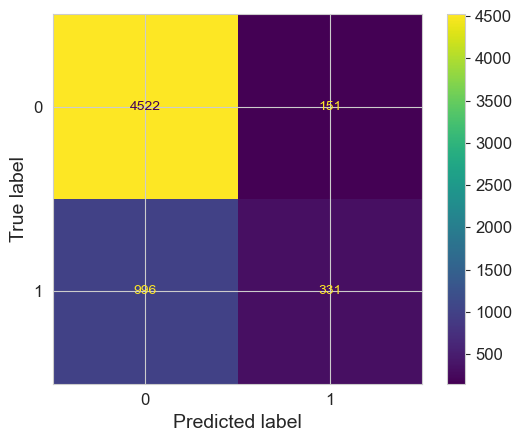

              precision    recall  f1-score   support

           0      0.819     0.968     0.887      4673
           1      0.687     0.249     0.366      1327

    accuracy                          0.809      6000
   macro avg      0.753     0.609     0.627      6000
weighted avg      0.790     0.809     0.772      6000



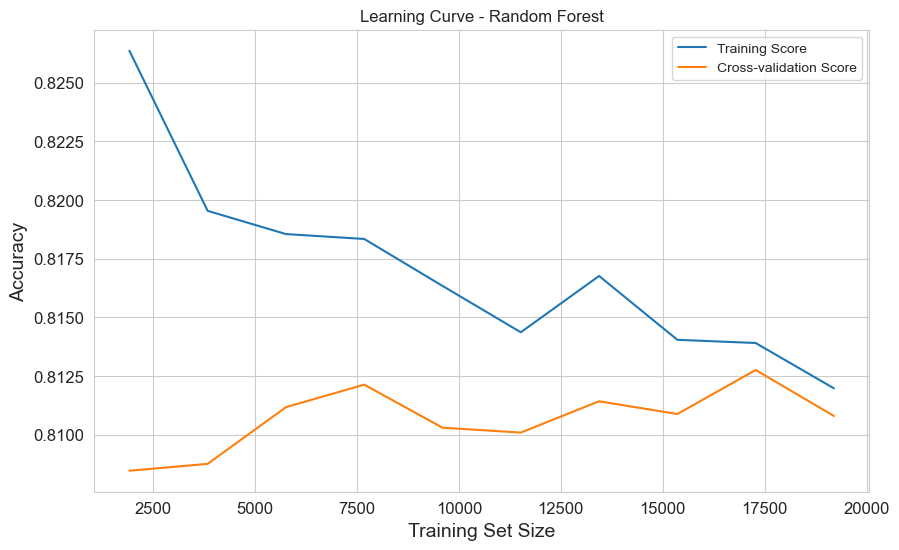

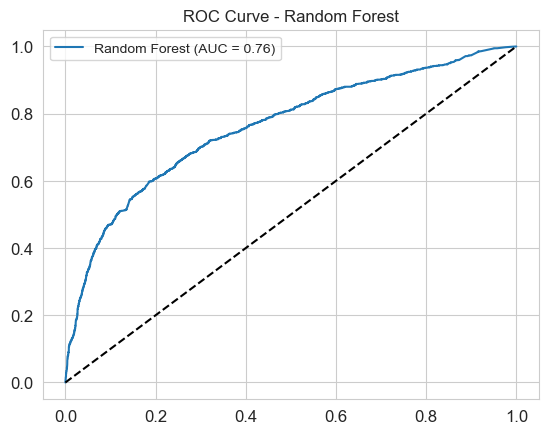

In [36]:
rnd_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
y_proba_rf = rnd_clf.predict_proba(X_test)

print("Random Forest")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.show()
print(classification_report(y_test, y_pred_rf, digits=3))
plot_learning_curve(rnd_clf, "Random Forest")

plot_roc("Random Forest", y_test, y_proba_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)

## AdaBoost

c:\Users\jverc\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost


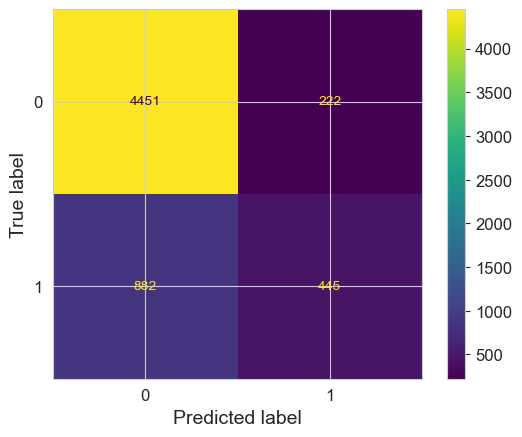

              precision    recall  f1-score   support

           0      0.835     0.952     0.890      4673
           1      0.667     0.335     0.446      1327

    accuracy                          0.816      6000
   macro avg      0.751     0.644     0.668      6000
weighted avg      0.798     0.816     0.792      6000



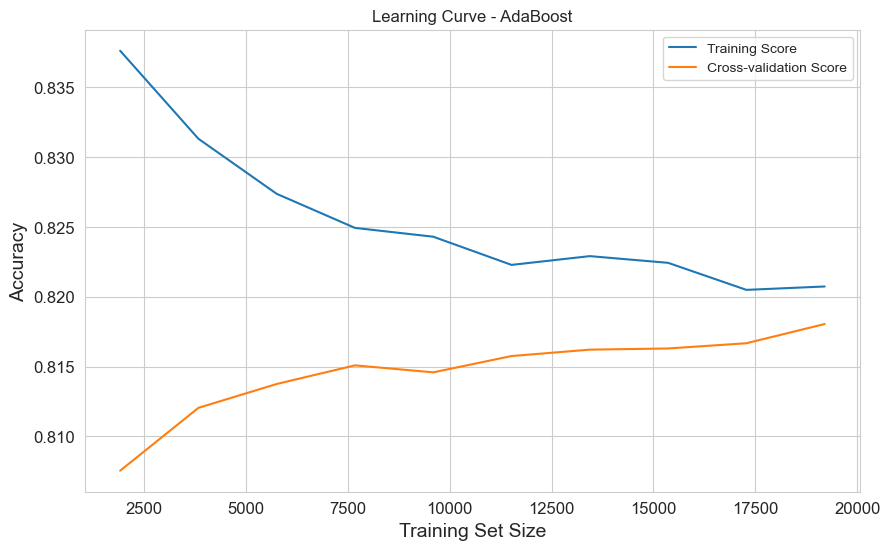

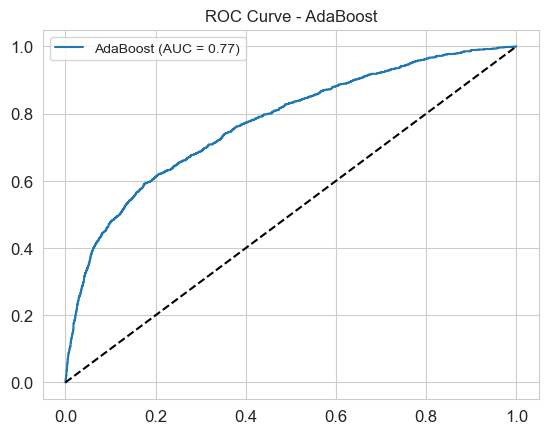

In [37]:
ada_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_model.fit(X_train, y_train)

y_pred_ada = ada_model.predict(X_test)
y_proba_ada = ada_model.predict_proba(X_test)

print("AdaBoost")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ada)
plt.show()
print(classification_report(y_test, y_pred_ada, digits=3))
plot_learning_curve(ada_model, "AdaBoost")

plot_roc("AdaBoost", y_test, y_proba_ada)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - AdaBoost")
plt.legend()
plt.grid(True)
plt.show()

evaluate_model("AdaBoost", y_test, y_pred_ada, y_proba_ada)


## Gradient Boosted Trees

Gradient Boosted Trees


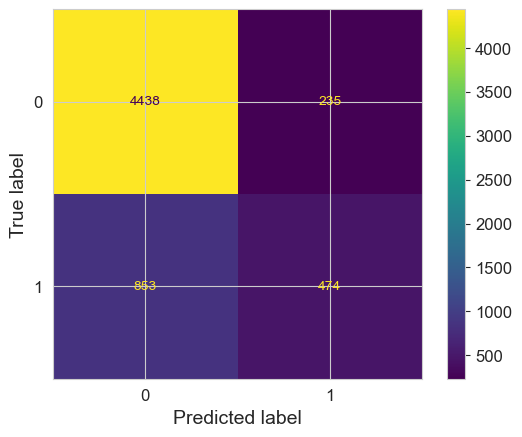

              precision    recall  f1-score   support

           0      0.839     0.950     0.891      4673
           1      0.669     0.357     0.466      1327

    accuracy                          0.819      6000
   macro avg      0.754     0.653     0.678      6000
weighted avg      0.801     0.819     0.797      6000



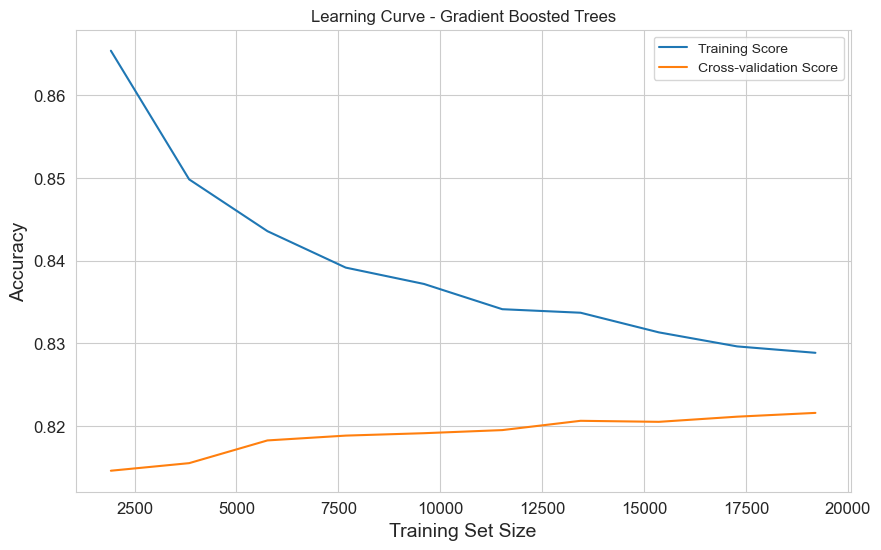

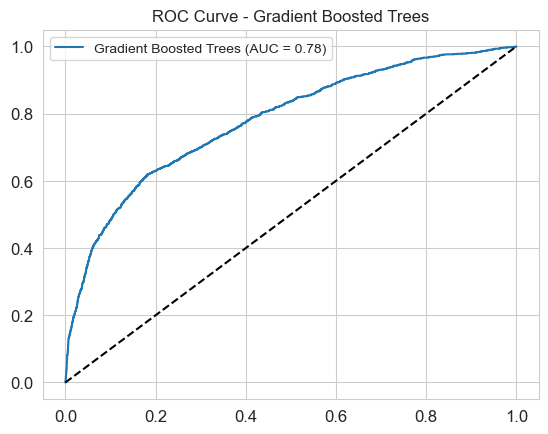

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn import ensemble

gb_model = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=random_state)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)


print("Gradient Boosted Trees")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb)
plt.show()
print(classification_report(y_test, y_pred_gb, digits=3))
plot_learning_curve(gb_model, "Gradient Boosted Trees")

plot_roc("Gradient Boosted Trees", y_test, y_proba_gb)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Gradient Boosted Trees")
plt.legend()
plt.grid(True)
plt.show()

evaluate_model("Gradient Boosted Trees", y_test, y_pred_gb, y_proba_gb)

In [39]:
results_df = pd.DataFrame(model_results)
display(results_df.sort_values("F1 Score", ascending=False))

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
2,Gradient Boosted Trees,0.818667,0.668547,0.357197,0.465619,0.779135
1,AdaBoost,0.816000,0.667166,0.335343,0.446339,0.771885
0,Random Forest,0.808833,0.686722,0.249435,0.365948,0.761336


#### Question 4 (3 pts)

Discuss and compare the results for the all past three questions. 

* How does changing hyperparms effect model performance? 
* Why do you think certain models performed better/worse? 
* How does this performance line up with known strengths/weakness of these models?